<a href="https://colab.research.google.com/github/cchavezg/LTSMmodel/blob/main/Assignment6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Prediction with sequential data**

### **1) Long Short Time Memory Model**

# 0. Important necessary modules

In [ ]:
import torch 
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1.Data Preparation

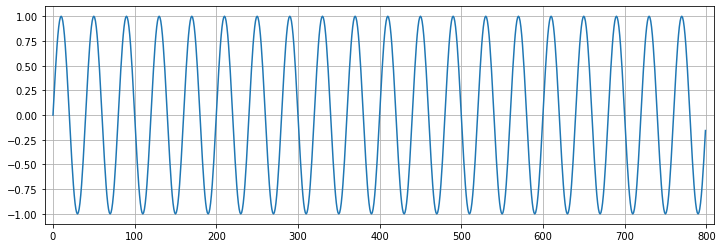

In [ ]:
x = torch.linspace(0,799, 800)
y = torch.sin(x * 2 * np.pi / 40)

plt.figure(figsize = (12,4))
plt.xlim(-10, 810)
plt.grid(True)
plt.plot(y.numpy() )

In [ ]:
test_size = 40
train_set = y[:-test_size]
test_set = y[-test_size:]
print(len(train_set), len(test_set))

760 40


### Inspecting dataset

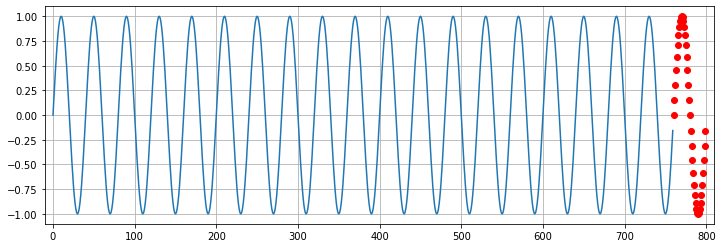

In [ ]:
plt.figure(figsize = (12,4))
plt.xlim(-10, 810)
plt.grid(True)
plt.plot(x[:-test_size].numpy(), y[:-test_size].numpy())
plt.plot(x[-test_size:].numpy(), y[-test_size:].numpy(), 'ro')

# 2. Model Define

### **Data window**

In [ ]:
def input_data(seq, ws):
    output = []   
    L = len(seq)
    print("length of input training data={}".format(L))
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        output.append((window, label))
    return output

In [ ]:
window_size = 40
train_data = input_data(train_set, window_size)
print(train_data[0][0], train_data[0][1])
print(train_data[1][0], train_data[1][1])

length of input training data=760
tensor([ 0.0000e+00,  1.5643e-01,  3.0902e-01,  4.5399e-01,  5.8779e-01,
         7.0711e-01,  8.0902e-01,  8.9101e-01,  9.5106e-01,  9.8769e-01,
         1.0000e+00,  9.8769e-01,  9.5106e-01,  8.9101e-01,  8.0902e-01,
         7.0711e-01,  5.8779e-01,  4.5399e-01,  3.0902e-01,  1.5643e-01,
        -8.7423e-08, -1.5643e-01, -3.0902e-01, -4.5399e-01, -5.8779e-01,
        -7.0711e-01, -8.0902e-01, -8.9101e-01, -9.5106e-01, -9.8769e-01,
        -1.0000e+00, -9.8769e-01, -9.5106e-01, -8.9101e-01, -8.0902e-01,
        -7.0711e-01, -5.8779e-01, -4.5399e-01, -3.0902e-01, -1.5643e-01]) tensor([1.7485e-07])
tensor([ 1.5643e-01,  3.0902e-01,  4.5399e-01,  5.8779e-01,  7.0711e-01,
         8.0902e-01,  8.9101e-01,  9.5106e-01,  9.8769e-01,  1.0000e+00,
         9.8769e-01,  9.5106e-01,  8.9101e-01,  8.0902e-01,  7.0711e-01,
         5.8779e-01,  4.5399e-01,  3.0902e-01,  1.5643e-01, -8.7423e-08,
        -1.5643e-01, -3.0902e-01, -4.5399e-01, -5.8779e-01, -7.0711e

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """Entry point for launching an IPython kernel.


<StemContainer object of 3 artists>

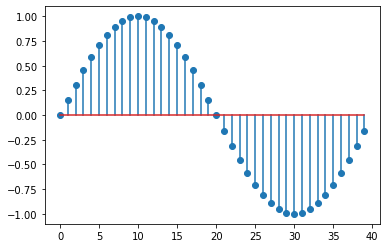

In [ ]:
plt.stem(train_data[0][0])

### **LSTM Model**

In [ ]:
# LSTM
class LongShortTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, out_size=1):
        super(LongShortTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, out_size)
        self.hidden = (torch.zeros(1,1,hidden_size), torch.zeros(1,1,hidden_size))

    def forward(self, seq):
        lstm_out, self.hidden = self.lstm(seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]

# 3. Simulation Define

In [ ]:
model = LongShortTM()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
print(model)

LongShortTM(
  (lstm): LSTM(1, 50)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)


In [ ]:
epochs = 20
future = 40
for i in range(epochs):
  for seq, y_train in train_data:
    optimizer.zero_grad()
    model.hidden = (torch.zeros(1,1,model.hidden_size) ,
                    torch.zeros(1,1,model.hidden_size))
    
    y_pred = model(seq)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()
 
  print(f"Epoch {i} Loss {loss.item()} ")
  
  preds = train_set[-window_size:].tolist()
  for f in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
      model.hidden = (torch.zeros(1,1,model.hidden_size) ,
                      torch.zeros(1,1,model.hidden_size))
      preds.append(model(seq).item())
 
  loss = criterion(torch.tensor(preds[-window_size :]), y[760:] )
  print(f'Performance on test range: {loss}')

Epoch 0 Loss 0.08139645308256149 
Performance on test range: 0.583743691444397
Epoch 1 Loss 0.04057369381189346 
Performance on test range: 0.5030266642570496
Epoch 2 Loss 0.006165090948343277 
Performance on test range: 0.24060288071632385
Epoch 3 Loss 0.0003419396816752851 
Performance on test range: 0.029637489467859268
Epoch 4 Loss 0.00016686729213688523 
Performance on test range: 0.01349420566111803
Epoch 5 Loss 0.0001680249988567084 
Performance on test range: 0.01031156349927187
Epoch 6 Loss 0.0001732025993987918 
Performance on test range: 0.008366860449314117
Epoch 7 Loss 0.00017495552310720086 
Performance on test range: 0.006967709865421057
Epoch 8 Loss 0.0001739258150337264 
Performance on test range: 0.0059264590963721275
Epoch 9 Loss 0.0001709800271783024 
Performance on test range: 0.0051344772800803185
Epoch 10 Loss 0.00016677491657901555 
Performance on test range: 0.00452050194144249
Epoch 11 Loss 0.00016178977966774255 
Performance on test range: 0.00403605727478861

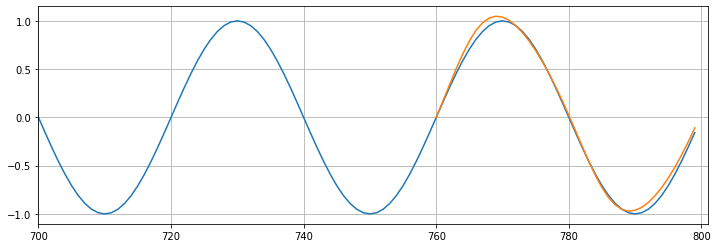

In [ ]:
plt.figure(figsize=(12,4))
plt.xlim(700, 801)
plt.grid(True)
plt.plot(y.numpy())
plt.plot(range(760,800), preds[window_size:])
plt.show()